In [1]:
from sbhandler import *
import pickle

In [2]:
# load_matlab_file function Testing
file_name = 'consensus1.mat'
variable_of_interest = 'align3'
h5py_object, data = load_matlab_file(file_name, variable_name=variable_of_interest)

# DNA_seqs can be used to grab each raw_seqblock
DNA_seqs = DNA_SeqBlocks(h5py_object=h5py_object, data=data) 

FILE_SIZE = DNA_seqs.size #Constant

In [3]:
# Load in barcodes and truelens for the day
df = pickle.load(open('pickle/v2BarcodesTruelen.pickle', 'rb'))
BARCODES = df.barcode
TRUELENS = df.true_len

In [4]:
# Make sure it works on a small dataset first.
tinyDS = range(1, 10001)
DS = range(1, FILE_SIZE+1)

## GET BFP-parsed seqblocks

In [ ]:
# bfp_list = []
# rfp_list = []

# for i in DS:
#     end = TRUELENS[i]
#     b, r = DNA_seqs.get_br(i, end)
#     bfp_list.append(b)
#     rfp_list.append(r)

In [6]:
# with open('pickle/raw_bfp.pickle', 'wb') as f:
#     pickle.dump(bfp_list, f)

# with open('pickle/raw_rfp.pickle', 'wb') as f:
#     pickle.dump(rfp_list, f)

In [5]:
# Load 'em in 
bfp_list = pickle.load( open('pickle/raw_bfp.pickle', 'rb'))
rfp_list = pickle.load( open('pickle/raw_rfp.pickle', 'rb'))

### Compositional Probability
- Support of each nucleotide
- Observe four types
    - BFP vs. RFP
    - target vs. reads 
        - truncate indels at the beginning... while (first_nuc != 45):

Count 'em up:
- Probability for BFP target, BFP reads
[0.27, 0.30, 0.27, 0.16, 0.00]
- Probability for RFP target, RFP reads:
[0.23, 0.32, 0.31, 0.15, 0.00]

BFP 

In [ ]:
bfp_targ_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))
bfp_read_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))

for n, bfp in enumerate(bfp_list[0:50_000]):
    if n % 3550 == 0: print(f'{100*(n/355104):.0f}%')
    if bfp.empty: continue
    targ = bfp['target']
    idx = 0
    if len(targ) > 2 and targ.iloc[0] == 45: # if it starts with an indel
        idx = 1
        while (targ.iloc[idx] == 45) and idx < len(targ):
            idx += 1
    for num in range(idx, len(targ)):
        bfp_targ_counter[chr(targ.iloc[num])] += 1
    cov = int( (len(bfp.columns) -4 )/2)
    for r in range(cov):
        read = bfp[f'read{r+1}']
        idx = 0
        if len(read) > 2 and read.iloc[0] == 45: # if it starts with an indel
            # print(len(read))
            idx = 1
            while (idx < len(read) and read.iloc[idx] == 45):
                # if (idx > 0 and idx % 100 == 0): print(bfp.index.name)
    
                idx += 1
        for num in range(idx, len(read)):
            bfp_read_counter[chr(read.iloc[num])] += 1


total_btc = sum(bfp_targ_counter.values())            
for nuc, val in bfp_targ_counter.items():
    print(f'{nuc}: {val/total_btc:.2f}')
    print('\n')
total_brc = sum(bfp_read_counter.values())
for nuc, val in bfp_read_counter.items():
    print(f'{nuc}: {val/total_brc:.2f}')


RFP

In [55]:
rfp_targ_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))
rfp_read_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))

for n, rfp in enumerate(rfp_list[0::50]):
    # print(n*50)
    if n % 3550 == 0: print(f'{n/355104:.2f}%')
    if rfp.empty: continue
    
    cov = int( (len(rfp.columns) -4 )/2)
    if cov > 3: 
        targ = rfp['contig']
        idx = 0
        len_targ = len(targ)
        if len(targ) > 1 and targ.iloc[0] == 45: # if it starts with an indel
            idx = 1
            while ( idx < len_targ and targ.iloc[idx] == 45):
                idx += 1
        for num in range(idx, len_targ):
            rfp_targ_counter[chr(targ.iloc[num])] += 1
    
    for r in range(cov):
        read = rfp[f'read{r+1}']
        idx = 0
        len_read = len(read)
        if len_read > 2 and read.iloc[0] == 45: # if it starts with an indel
            # print(len(read))
            idx = 1
            while (idx < len_read and read.iloc[idx] == 45):
                # if (idx > 0 and idx % 100 == 0): print(rfp.index.name)
    
                idx += 1
        end = len_read
        if (read[-3:] == [45, 45, 45]).all():
            end = len_read - 4
            while idx < (end - 1) and read.iloc[end] == 45:
                end = end - 1
            
        for num in range(idx, end): 
            rfp_read_counter[chr(read.iloc[num])] += 1

total_rtc = sum(rfp_targ_counter.values())            
for nuc, val in rfp_targ_counter.items():
    print(f'{nuc}: {val/total_rtc:.2f}')
print('\n')
total_rrc = sum(rfp_read_counter.values())
for nuc, val in rfp_read_counter.items():
    print(f'{nuc}: {val/total_rrc:.2f}')

0.00%
0.01%
0.02%
A: 0.23
C: 0.32
G: 0.31
T: 0.15
-: 0.00


A: 0.23
C: 0.32
G: 0.31
T: 0.15
-: 0.00


### Sequencing Error Rates? Reflect by adjusting the Q score
- Truth known. What is it being mistaken for? 
- Create a 5x5 matrix

Obtain the frequency of correct vs error

In [206]:
# 287 minutes
# -----
# For each qscore (except 32): track value[0] observed, value[1] incorrect
each_qscore = {'correct' : 0, 'A' : 0, 'C' : 0, 'G' : 0, 'T' : 0, '-' : 0}

# tracking = {'A' : { i : each_qscore for i in np.arange(32,127) },
            # 'C' : { i : each_qscore for i in np.arange(32,127) },
            # 'T' : { i : each_qscore for i in np.arange(32,127) },
            # 'G' : { i : each_qscore for i in np.arange(32,127) },
            # '-' : { i : each_qscore for i in np.arange(32,127) }}
tracking = {'A' : { i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            'C' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            'G' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            'T' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            '-' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)}}

def hot_encode(num):
    if num == 65: return 1
    elif num == 67: return 2
    elif num == 71: return 3
    elif num == 84: return 4
    else: return 5
    
for bfp in bfp_list:
    cov = int((len(bfp.columns)-4)/2) # New rename() will include it in the first two chars
    for read_num in range(1, cov+1):
        read = bfp[f'read{read_num}']
        for nuc in range(len(read.index)):
            true_nuc = bfp.iloc[nuc,0]
            chr_tnuc = chr(true_nuc) # convert to a chr the targ
            qscore = bfp[f'q{read_num}'].iloc[nuc] # The qscore
            check = read.iloc[nuc] # 
            if check == true_nuc: # If correct. Add to observed
                # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                # tracking[chr_tnuc][qscore]['correct'] += 1
                tracking[chr_tnuc][qscore][0] += 1
            else: # If they disagree
                # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct':0, 65:0,67:0,71:0,84:0,45:0})
                # tracking[chr_tnuc][qscore][chr(check)] += 1
                tracking[chr_tnuc][qscore][hot_encode(check)] +=1        

Reformat into a 5x5 matrix

In [161]:
tracking['A']

{32: [0, 0, 0, 0, 0, 0],
 33: [0, 0, 0, 0, 0, 6710278],
 34: [0, 0, 0, 0, 0, 0],
 35: [367, 0, 57, 51, 101, 0],
 36: [20411, 0, 649, 766, 992, 0],
 37: [36319, 0, 862, 1012, 1167, 0],
 38: [32671, 0, 726, 888, 923, 0],
 39: [32066, 0, 592, 766, 709, 0],
 40: [32014, 0, 498, 711, 592, 0],
 41: [32013, 0, 462, 703, 551, 0],
 42: [33075, 0, 414, 561, 494, 0],
 43: [34488, 0, 390, 547, 469, 0],
 44: [35915, 0, 346, 515, 406, 0],
 45: [37854, 0, 315, 505, 376, 0],
 46: [39757, 0, 314, 446, 370, 0],
 47: [42214, 0, 293, 461, 347, 0],
 48: [45263, 0, 297, 461, 340, 0],
 49: [48383, 0, 279, 407, 289, 0],
 50: [51308, 0, 288, 374, 276, 0],
 51: [54840, 0, 253, 380, 273, 0],
 52: [58229, 0, 224, 387, 222, 0],
 53: [62857, 0, 237, 362, 249, 0],
 54: [65741, 0, 225, 348, 222, 0],
 55: [70897, 0, 213, 332, 211, 0],
 56: [76217, 0, 202, 375, 206, 0],
 57: [82867, 0, 185, 301, 191, 0],
 58: [87593, 0, 166, 328, 210, 0],
 59: [93682, 0, 163, 282, 175, 0],
 60: [101408, 0, 184, 273, 177, 0],
 61: [1082

### Include RFP with high coverage
- Advised by Yiyang to increase sample size: principle is that high coverage contigs (4+) is true for all practical purposes 

In [236]:
#78 minutes
for rfp in rfp_list:
    cov = int((len(rfp.columns)-4)/2)
    if cov > 3:
        for read_num in range(1, cov+1):
            read = rfp[f'read{read_num}']
            true = rfp.loc[:, 'contig']
            for nuc in range(len(read.index)):
                true_nuc = true.iloc[nuc]
                chr_tnuc = chr(true_nuc) # convert to a chr the targ
                qscore = rfp[f'q{read_num}'].iloc[nuc] # The qscore
                check = read.iloc[nuc] # 
                if check == true_nuc: # If correct. Add to observed
                    # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                    # tracking[chr_tnuc][qscore]['correct'] += 1
                    tracking[chr_tnuc][qscore][0] += 1
                else: # If they disagree
                    # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct':0, 65:0,67:0,71:0,84:0,45:0})
                    # tracking[chr_tnuc][qscore][chr(check)] += 1
                    tracking[chr_tnuc][qscore][hot_encode(check)] +=1        
            

### Correcting Q Score

In [81]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


raw_x = [i for i in np.arange(35, 127)] #34 is 0 in test

for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y

In [82]:
for nuc in to_plot:
    focus = to_plot[nuc]
    for n, num in enumerate(focus):
        focus[n] = 33 - (10 * np.log10(num))

In [160]:
tracking['-']

{32: [0, 0, 0, 0, 0, 0],
 33: [4676053, 0, 0, 0, 0, 0],
 34: [0, 0, 3, 1, 0, 0],
 35: [0, 191, 135, 122, 112, 0],
 36: [0, 2858, 2729, 2426, 1953, 0],
 37: [0, 4149, 4029, 3683, 2816, 0],
 38: [0, 3457, 3329, 3093, 2260, 0],
 39: [0, 3012, 2894, 2682, 1902, 0],
 40: [0, 2720, 2701, 2391, 1791, 0],
 41: [0, 2471, 2575, 2263, 1629, 0],
 42: [0, 2399, 2393, 2122, 1489, 0],
 43: [0, 2309, 2173, 1992, 1475, 0],
 44: [0, 2202, 2172, 1899, 1367, 0],
 45: [0, 2104, 2097, 1868, 1267, 0],
 46: [0, 2087, 2022, 1795, 1230, 0],
 47: [0, 1970, 2037, 1818, 1134, 0],
 48: [0, 1865, 1918, 1778, 1105, 0],
 49: [0, 1883, 1940, 1787, 1152, 0],
 50: [0, 1820, 1967, 1756, 1088, 0],
 51: [0, 1817, 2012, 1767, 1090, 0],
 52: [0, 1786, 1916, 1688, 1122, 0],
 53: [0, 1814, 1937, 1696, 1033, 0],
 54: [0, 1791, 1945, 1785, 1044, 0],
 55: [0, 1717, 1993, 1765, 974, 0],
 56: [0, 1756, 1890, 1788, 940, 0],
 57: [0, 1699, 1945, 1823, 1001, 0],
 58: [0, 1679, 1953, 1810, 949, 0],
 59: [0, 1721, 2006, 1715, 1001, 0],
 

Text(0, 0.5, 'Observed Q Score')

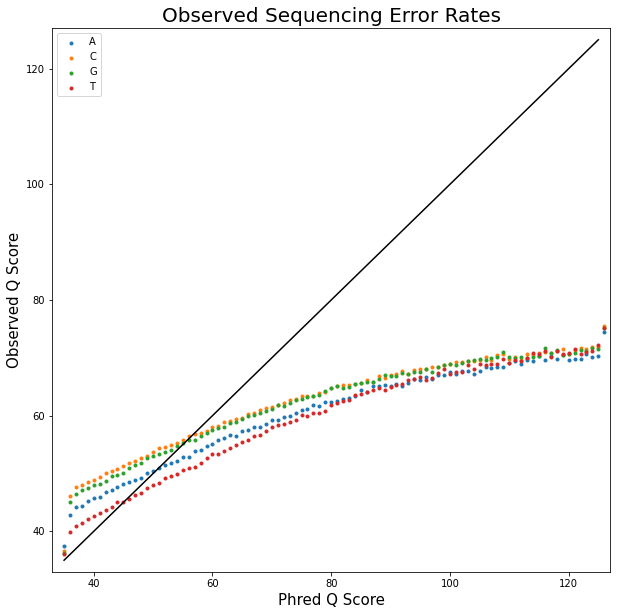

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for nuc in to_plot:
    plt.scatter(raw_x, to_plot[nuc], marker='.', label=nuc)
plt.plot(np.arange(35, 126), np.arange(35, 126), color='k')
plt.legend()
plt.xlim([33, 127])
plt.ylim([33, 127])
plt.title('Observed Sequencing Error Rates', fontsize=20)
plt.xlabel('Phred Q Score', fontsize=15)
plt.ylabel('Observed Q Score', fontsize=15)


In [154]:
store = pd.DataFrame(to_plot, index=np.arange(35, 127))

In [155]:
with open('pickle/observed_qscore.pickle', 'wb') as f:
    pickle.dump(store, f)

In [138]:
test = []
AT = []
AC = []
AG = []
AI = []

for q, freq in tracking['A'].items():
    test.append(q)
    total = freq[0]
    check = freq[2:]
    for idx, num in enumerate(check):
        if idx == 0:
            if total == 0: AC.append(0)
            else: AC.append(num/total)
        elif idx == 1:
            if total == 0: AG.append(0)
            else: AG.append(num/total)
        elif idx == 2:
            if total == 0: AT.append(0)
            else: AT.append(num/total)
        elif idx == 3:
            if total == 0: AI.append(0)
            else: AI.append(num/total)
        else: print(f"?{q} {idx} {num}")
plt.figure(figsize=(10,10))
plt.plot(test, AC)
plt.plot(test, AG)
plt.plot(test, AT)
plt.plot(test, AI)

    

IndentationError: unexpected indent (837858696.py, line 2)

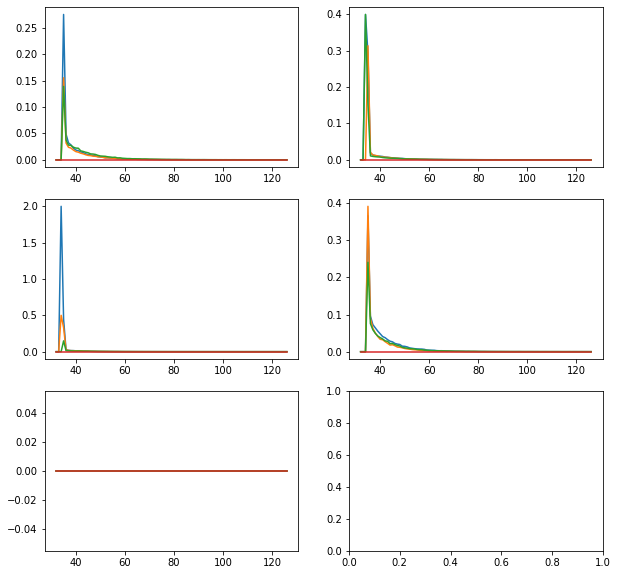

In [147]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
skip = {'A':0, 'C':1, 'G':2, 'T':3, '-':4}

for nuc in ['A', 'C', 'G', 'T', '-']:
    test = []
    AT = []
    AC = []
    AG = []
    AI = []

    for q, freq in tracking[nuc].items():
        test.append(q)
        total = freq[0]
        check = freq[1:]
        check.pop(skip[nuc])
        for idx, num in enumerate(check):
            if idx == 0:
                if total == 0: AC.append(0)
                else: AC.append(num/total)
            elif idx == 1:
                if total == 0: AG.append(0)
                else: AG.append(num/total)
            elif idx == 2:
                if total == 0: AT.append(0)
                else: AT.append(num/total)
            elif idx == 3:
                if total == 0: AI.append(0)
                else: AI.append(num/total)
            else: continue
    if nuc =='A':
        axes[0,0].plot(test, AT)
        axes[0,0].plot(test, AC)
        axes[0,0].plot(test, AG)
        axes[0,0].plot(test, AI)
    elif nuc =='C':
        axes[0,1].plot(test, AT)
        axes[0,1].plot(test, AC)
        axes[0,1].plot(test, AG)
        axes[0,1].plot(test, AI)
    elif nuc =='G':
        axes[1,0].plot(test, AT)
        axes[1,0].plot(test, AC)
        axes[1,0].plot(test, AG)
        axes[1,0].plot(test, AI)
    elif nuc == 'T':
        axes[1,1].plot(test, AT)
        axes[1,1].plot(test, AC)
        axes[1,1].plot(test, AG)
        axes[1,1].plot(test, AI)
    else:
        axes[2,0].plot(test, AT)
        axes[2,0].plot(test, AC)
        axes[2,0].plot(test, AG)
        axes[2,0].plot(test, AI)


In [6]:
tracking = pickle.load( open('pickle/v2TrackingwRFP.pickle', 'rb'))

### Plotting Nucleotide-specific Error Patterns

In [ ]:
tracking_vocab = ['correct', 'A', 'C', 'G', 'T', '-']
skip = {'A' : 0, 'C' : 1, 'G': 2, 'T': 3}
associate = {0 : 'A', 1: 'C', 2: 'G', 3: 'T'}

x = [i for i in np.arange(33, 126)]
for nuc in ['A']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 45: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'C', 'G', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')
        plt.tight_layout()

In [ ]:
x = [i for i in np.arange(39, 126)]
for nuc in ['C']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'G', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')
        plt.tight_layout()

In [ ]:

for nuc in ['G']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'C', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')  
        plt.tight_layout()

In [ ]:
for nuc in ['T']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'C', 'G'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')

### VISUALIZE: Real Error of z and yyy

#### Z Conflicts

- Currently: Plot total wrong / all instances of reads vs true
- Line of best fit plotted at Q > 45


In [248]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


raw_x = [i for i in np.arange(35, 127)] #34 is 0 in test

for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y




Take the log if non-zero. Motive: linear graph

In [254]:
%matplotlib inline
import math
import matplotlib.pyplot as plt

for nuc in ['A', 'C', 'G', 'T']:
    to_change = to_plot[nuc]
    for i in range(len(to_change)):
        if to_change[i] == 0: 
            to_change[i] = 0 
        else: 
            to_change[i] = math.log(to_change[i])


Fill in missing values with a mean (only present at low sample sizes)

In [80]:
for nuc in ['A', 'C', 'G', 'T']:
    fix = to_plot[nuc]
    for i in range(len(fix)):
        if fix[i] == 0:
            fix[i] = 0.5*(fix[i-1]+fix[i+1])

Plot the 4 nucleotides 

In [ ]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,10))
plt.subplots_adjust(wspace=0,hspace=0)

axes[0,0].scatter(raw_x, to_plot['A'], c='red',s=12)
axes[0,1].scatter(raw_x, to_plot['C'], c='blue', s=12)
axes[1,0].scatter(raw_x, to_plot['G'], c='green',s=12)
axes[1,1].scatter(raw_x, to_plot['T'], c='purple',s=12)

# Needs to be calculated below
# axes[0,0].scatter(x, lobA, c='black')
# axes[0,1].scatter(x, lobC, c='black')
# axes[1,0].scatter(x, lobG, c='black')
# axes[1,1].scatter(x, lobT, c='black')

# # Check something...
# for i in range(2):
#     for j in range(2):
#         axes[i,j].hlines(0.01, 35, 126)

labels = ['A', 'C', 'G', 'T']
# labels_with_lobf = ['A', '_lobfA', 'C', '_lobfC',  'G', '_lobfG',  'T', '1e-2']
fig.legend(labels=labels, loc="right")
fig.suptitle('Associating Error Rate with Phred Q Score (n=455,157)', fontsize=25)
fig.supxlabel('Phred Q scores', fontsize=20)
fig.supylabel('Log_10 Adjusted Real Error Rate', fontsize=20)
# fig.supylabel('Real Error Rate', fontsize=20)





In [242]:
# count = 0
# for rfp in rfp_list:
#     if int((len(rfp.columns)-4)/2) > 3:
#         count += 1
# count

100053

### Line of best fits
- Calculated using ML and after Q = 45


In [94]:
# Assessing if contig is a viable thing to use for RFP Truth
for x,rfp in enumerate(rfp_list):
    if DNA_seqs.get_coverage_count(x+1) > 3:
        if rfp.empty: continue
        muts = rfp['changes']
        if len(muts[muts==122]) > 1:
            print(x+1)
            break

59


Using torch to calculate line of best fit

In [168]:
# Desired func y = mx + b => # params are m, b
import torch
p = torch.randn(2).requires_grad_()

In [169]:
x = torch.tensor(np.arange(46, 127)).long()
yA = torch.tensor(to_plot['A'][11:]).float()
yC = torch.tensor(to_plot['C'][11:]).float()
yG = torch.tensor(to_plot['G'][11:]).float()
yT = torch.tensor(to_plot['T'][11:]).float()

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x,self.y = x,y
        self.len = len(x)
        
    def __len__(self): return self.len
    
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

testdsA = torch.utils.data.DataLoader(Dataset(x,yA), batch_size=3)
testdsC = torch.utils.data.DataLoader(Dataset(x,yC), batch_size=5)
testdsG = torch.utils.data.DataLoader(Dataset(x,yG), batch_size=5)
testdsT = torch.utils.data.DataLoader(Dataset(x,yT), batch_size=5)

In [ ]:
def func(params, input):
    a, b = params
    return a*input + b

import torch.functional as F
from fastai.vision.all import *
from fastbook import *

def loss_func(pred, targ):
    # Let's use RMSE
    return ((pred-targ)**2).sqrt()

lr = 1e-5
for i in range(1000):
    loss_total = 0
    n_obs = 0
    for xin, yin in testdsT:
        
        pred = func(p, xin)
        loss = loss_func(pred, yin).mean()
        
        loss.backward() 
        p.data -= p.grad.data * lr
        p.grad = None
        
        n = len(xin)
        loss_total += loss.item()*n
        n_obs +=n
        
    print(loss_total/n_obs)

In [178]:
def f(x):
    a,b =p.data
    return a*x+b

In [183]:
lobT = []
for i in x:
    lobT.append(f(i))

#### YYY Conflicts

- Two main categories:
    - Insertion (Target, non-agreeing reads have '-' for alignment)
    - Deletion  (Only read has '-' for alignment) 

&nbsp;


- Insertion types:
    - Misaligned multi-insertions 
        - e.g. aligned as G-GG-AG / G**G**G*A*GAG when it should be GGG--AG / GGG**AG**AG) 
    - Multi-insertions (G--G / GAAG)
        - [4y+]
    - **Harmonious** Insert
        - Matches left AND right
    - **1x Discord** Insert
        - Matches left OR right nuc
    - **2x Discord** Insert
        - No match with left OR right
<br>      
&nbsp;
- Deletion types: (Note: the thing that *matches* is the truth that was deleted)
    - **Harmonious** del
        - Matches left AND right nuc
    - **1X Discord** del 
        - Matches left OR right nuc 
    - **2x Discord** del 
        - No match with left OR right [e.g. A-G when others say A**C**G]

Checking Difference in Error Counts between Nucleotides
- Not shown: spikes at Q=126
    - A ~ 20,000; C,G ~ 18,000; T ~ 10,000

In [ ]:
tracking_vocab = ['correct', 'A', 'C', 'G', 'T', '-']
tracking['A']

for nuc in ['A', 'C', 'G', 'T']:
    error_frequency = []
    for q, v in tracking[nuc].items():
        if q > 34:
            error_frequency.append(sum(v[1:]))
    q_related = [x for x in np.arange(35, 126)]
    plt.plot(q_related, error_frequency[:-1])
    # print(np.argmax(error_frequency[:-1]), max(error_frequency[:-1]))
    # print(error_frequency[2])
plt.legend(labels=['A', 'C', 'G', 'T'])
plt.ylabel('Error Count')
plt.xlabel('Phred Quality Score')
    # max_freq = max(error_frequency[:-1])
    # norm = [item/max_freq for item in error_frequency[:-1]]
    # plt.plot(q_related, norm)
    # plt.text(126, error_frequency[-1]-20_000, "%d" %error_frequency[-1] + nuc, ha="right")

&nbsp;

**Resolution**
- No Q score difference:
    - (! is an insert) \~\~\~ vs. ~!~ => \~\~\~ wins


In [ ]:
# Search for where there are y conflicts (once the first y is found. Keep checking "changes" column along nuc++ until a non-y char is found)
# Return the view of BFP or RFP with the continuous chunk of y's

def is_insertion(df):
    if (df['targ'][df['targ'] == 45]).empty: # If the target has NO indels
        return True # Means it's a INSERTION
    return False

def is_harmonious(df, coverage):
    for num in range(1, coverage+1):
        read = df[f'read{num}']
         
    

## Training a LogReg model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZConflicts(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        pass
        
class LinReg(nn.Module):
    
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        pass
        